# **Clasificación entre Melanoma Benigno y Maligno mediante Redes Neuronales Convolucionales (CNN)**

**Autores:**
*   Erick Maximiliano González Alvarado
*   Roberto Abdón Hernández García




# Resumen

El melanoma es una de las formas más agresivas de cáncer de piel, su detección temprana es de extrema prioridad para reducir el riesgo de muerte. El presente proyecto tiene como objetivo desarrollar y evaluar un modelo de Aprendizaje Profundo (Deep Learning) basado en Redes Neuronales Convolucionales (CNN) capaz de clasificar imágenes de melanoma en dos categorías clínicas: Benigno y Maligno. Para ello se inspeccionó, procesó y normalizó un conjunto de datos conformado exclusivamente por imágenes de melanoma benigno y maligno, el cual fue dividido en subconjuntos de entrenamiento, validación y prueba.

# Importación de Librerías y Herramientas

Para la implementación del flujo de trabajo, se estableció un entorno basado en las siguientes bibliotecas:

* **TensorFlow y Keras:** Marcos de trabajo principales para la construcción, compilación y entrenamiento de la arquitectura de aprendizaje profundo.
* **NumPy:** Utilizada para la manipulación eficiente de tensores y operaciones algebraicas sobre los datos de imágenes.
* **Scikit-Learn:** Empleada para el cálculo de métricas de evaluación (reporte de clasificación y matriz de confusión).
* **Matplotlib y Seaborn:** Herramientas para la visualización de datos, curvas de aprendizaje y representación gráfica del desempeño del modelo.
* **OS, Pathlib y Zipfile:** Conjunto de utilidades para la gestión del sistema de archivos, manejo de rutas y la extracción automatizada del conjunto de datos comprimido.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile, os
from pathlib import Path

# Manejo del flujo de datos

El flujo de datos y la arquitectura del modelo se diseñaron considerando las restricciones y ventajas del entorno de ejecución (Google Colab).

Dentro del conjunto de datos se identificó una variabilidad en la relación de aspecto de las muestras (formatos 4:3 y 1:1 o, bien, $600 \times 450$ píxeles y $300 \times 300$, respectivamente). Estandarizar el set de datos a una relación de aspecto rectangular (ej. 4:3) implicaría introducir márgenes de relleno en las imágenes cuadradas o recortar información relevante.

Para mantener la consistencia del tensor de entrada y maximizar el área analizada, se optó por redimensionar todas las imágenes a un formato cuadrado estándar de $128 \times 128$ píxeles. Adicionalmente, se reduce la resolución de las imágenes disminuyendo significativamente el uso de recursos como CPU y GPU, optimizando el uso de memoria y acelerando el tiempo de entrenamiento del modelo.

### Definición de constantes operativas y conexión al sistema

Para garantizar la persistencia de los recursos y la reproducibilidad del entorno, se optó por extraer los datos desde Google Drive. Se definieron además variables generales en esta sección.

In [ ]:
# Ruta del archivo zip del cual se importarán las imágenes
ZIP_PATH = "/content/drive/MyDrive/Melanoma_Data/Dataset_Melanoma_Cancer.zip"
# Ruta a donde será extraído el contenido
EXTRACT_TO = "/content/melanoma_extracted"
# Tamaño de cada imagen en pixeles
IMG_SIZE = (128, 128)
# Tamaño del lote de imágenes a procesar
BATCH_SIZE = 32

# Conexión de Drive a Google Colab para importación de archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extracción y Preparación del Dataset

Debido a que el conjunto de datos se distribuye en formato comprimido (ZIP) para optimizar su almacenamiento y transferencia, es necesario realizar una extracción local para permitir el acceso aleatorio a las imágenes durante el entrenamiento.

In [ ]:
# Extracción local del archivo zip
if not os.path.exists(EXTRACT_TO) or not any(Path(EXTRACT_TO).iterdir()):
    print(f"Iniciando descompresión del archivo: {ZIP_PATH}")
    print("Por favor espere, este proceso puede demorar dependiendo del volumen de datos...")

    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_TO)

    print(f"Descompresión finalizada exitosamente. Datos disponibles en: {EXTRACT_TO}")
else:
    print(f"Verificación completada: El conjunto de datos ya existe en {EXTRACT_TO}. Se omite la extracción.")

Iniciando descompresión del archivo: /content/drive/MyDrive/Melanoma_Data/Dataset_Melanoma_Cancer.zip
Por favor espere, este proceso puede demorar dependiendo del volumen de datos...
Descompresión finalizada exitosamente. Datos disponibles en: /content/melanoma_extracted


### Definición de la Jerarquía de Directorios

Tras la extracción, se establece la ruta raíz absoluta (`DATA_ROOT`) que servirá como punto de referencia para el empleo de los datos.

In [ ]:
# Definición de la ruta raíz de donde se usarán los datos
DATA_ROOT = Path(EXTRACT_TO) / "Data_Melanoma_Cancer"

print(f"Directorio raíz del dataset establecido en: {DATA_ROOT}")

Directorio raíz del dataset establecido en: /content/melanoma_extracted/Data_Melanoma_Cancer


### Carga y Configuración del Dataset

Se define la función auxiliar `load_ds` utilizando `image_dataset_from_directory`. Esta función estandariza la carga de los conjuntos de entrenamiento, validación y prueba bajo los siguientes criterios:

* **`shuffle`:** Se activa solo para el conjunto de entrenamiento. Esto rompe el orden de las imágenes en cada época, ayudando al modelo a converger mejor. Validación y prueba se mantienen intactos.
* **`label_mode='binary'`:** Codifica las etiquetas como valores flotantes (`float32`), formato requerido para nuestra configuración.
* **Rendimiento (`AUTOTUNE`):** Permite que TensorFlow optimice dinámicamente el uso de la CPU para la carga de datos en paralelo.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def load_ds(split, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        str(DATA_ROOT / split),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        label_mode='binary'
    )

# Definición de los conjuntos de datos
train_ds = load_ds("train", shuffle=True)
val_ds   = load_ds("validation", shuffle=False)
test_ds  = load_ds("test", shuffle=False)

# Verificar clases existentes en el conjunto de entrenamiento
class_names = train_ds.class_names
num_classes = len(class_names)

# Verificar clases existentes
datasets = {"Entrenamiento": train_ds, "Validación": val_ds, "Prueba": test_ds}

for name, ds in datasets.items():
    print(f"Clases en {name}: {ds.class_names}")

Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Clases en Entrenamiento: ['benign', 'malignant']
Clases en Validación: ['benign', 'malignant']
Clases en Prueba: ['benign', 'malignant']


### Preprocesamiento y Optimización del Rendimiento

Las imágenes digitales se representan originalmente con valores de intensidad de píxeles en el rango de enteros $[0, 255]$. Para garantizar la estabilidad numérica y facilitar la convergencia del algoritmo de optimización, se implementó una capa de **normalización** que reescala estos valores al intervalo $[0, 1]$.

Adicionalmente, se configuró el *pipeline* de datos para maximizar la eficiencia del hardware mediante dos transformaciones críticas:
1.  **`cache()`:** Almacena las imágenes en memoria (RAM) tras la primera época, eliminando la latencia de lectura de disco en épocas subsecuentes.
2.  **`prefetch(buffer_size=AUTOTUNE)`:** Desacopla la ejecución de la CPU y la GPU, permitiendo que el procesador prepare el siguiente lote de datos mientras la tarjeta gráfica entrena con el actual.

In [ ]:
normalizer = keras.layers.Rescaling(1.0 / 255)

def prep(ds):
    """
    Aplica normalización y estrategias de optimización de carga (cache y prefetch).
    """
    ds = ds.map(lambda x, y: (normalizer(x), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

# Aplicación del preprocesamiento a los subconjuntos
train_model_ds = prep(train_ds)
val_model_ds   = prep(val_ds)
test_model_ds  = prep(test_ds)

# Exploración y Verificación de Datos

Previo al inicio de la fase de entrenamiento, es recomendable validar la integridad de los flujos de datos generados. Se implementó un procedimiento de inspección para extraer un lote (*batch*) individual del conjunto de prueba y corroborar las dimensiones de los tensores resultantes.

### Inspección Dimensional de Tensores

Mediante la instanciación de un iterador sobre el objeto `dataset`, se recupera el primer lote de datos disponible para su análisis. Esta operación permite auditar las dimensiones físicas de los tensores, asegurando que las imágenes cumplen con la estructura tetradimensional $(B, H, W, C)$ —donde $B$ es el tamaño del lote, $H$ y $W$ la resolución espacial, y $C$ los canales de color— y que las etiquetas se encuentran correctamente vectorizadas.

In [ ]:
iterator = iter(train_model_ds)

images, labels = next(iterator)

# Mostrar la forma de los lotes completos
print(f"Forma del tensor de imágenes (B, H, W, C): {images.shape}")
print(f"Forma del tensor de etiquetas: {labels.shape}")

Forma del tensor de imágenes (B, H, W, C): (32, 128, 128, 3)
Forma del tensor de etiquetas: (32, 1)


### Inspección Visual y Análisis de Distribución de Muestras

Con el propósito de certificar la idoneidad de los datos que alimentan la red, se lleva a cabo una validación sobre un lote del conjunto de entrenamiento. Este procedimiento inicia con una inspección de una instancia arbitraria del tensor, orientada a confirmar que las operaciones de redimensionamiento y normalización mantienen la integridad de las características.

Complementariamente, se audita la heterogeneidad del lote mediante el análisis de la distribución de etiquetas.

Dimensiones del lote: (32, 128, 128, 3)
Etiqueta de la muestra 5: [0.] (0=Benign, 1=Malignant)


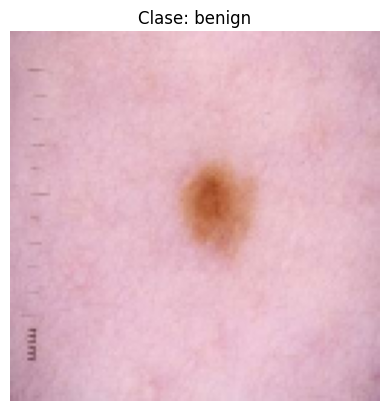


Distribución de clases en el lote actual:
Clase 0.0 (benign): 17 muestras
Clase 1.0 (malignant): 15 muestras


In [ ]:
IMG_ID = 5 # Muestra arbitraria dentro del lote

# Verificación de dimensiones y etiqueta asociada
print(f"Dimensiones del lote: {images.shape}")
print(f"Etiqueta de la muestra {IMG_ID}: {labels[IMG_ID].numpy()} (0=Benign, 1=Malignant)")

# Visualización de la muestra
plt.imshow(images[IMG_ID])
plt.axis("off")
plt.title(f"Clase: {class_names[int(labels[IMG_ID])]}")
plt.show()

# Análisis de la distribución de clases en este lote de entrenamiento
values, counts = np.unique(labels.numpy(), return_counts=True)

print("\nDistribución de clases en el lote actual:")
for v, c in zip(values, counts):
    print(f"Clase {v} ({class_names[int(v)]}): {c} muestras")

# Construcción del modelo - Red neuronal convolucional (CNN)

El modelo que se utiliza es una red neuronal convolucional (CNN). Este tipo de modelos es eficiente en la detección de patrones que existen dentro de las imágenes. En la mayoría de los casos, es posible distinguir patrones dentro de un melanoma, como formas, bordes o texturas.

### Estructura del modelo creado

La estructura del modelo, en términos simples, funciona así:

* Extracción de características: Las primeras capas del modelo (`Conv2D` y `MaxPooling`) observan a la imagen y determinan patrones y características que distinguen a un melanoma benigno de uno maligno.
* Transformación a una representación compacta: Antes de tomar una decisión, la imagen procesada se convierte en un vector por medio de `Flatten`. Esto permite que la red trabaje con los datos como si fueran una lista de características.
* Toma de decisión: La capa Dense usa toda la información aprendida para decidir si la imagen pertenece a una clase o no.
* La última capa usa una función `sigmoid`, o que hace que el resultado final sea un valor entre $0$ y $1$ (similar a una probabilidad).

In [ ]:
# Modelo
model = keras.Sequential()

model.add(keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,713 (12.47 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

# Arquitectura de la Red Neuronal Convolucional (CNN) propuesta para la detección de melanoma

### Diagrama de la Arquitectura del Modelo


El modelo recibe imágenes RGB de $128 \times 128$ píxeles. Consta de una fase de extracción de características (Feature Extraction) compuesta por tres capas convolucionales (con 32, 64 y 64 filtros respectivamente).

Se aplican operaciones de Max Pooling tras las dos primeras capas convolucionales para reducir la dimensionalidad. Posteriormente, los datos son aplanados (Flatten) para ingresar a la fase de clasificación, la cual cuenta con una capa densa de 64 neuronas y finaliza en una neurona de salida con activación sigmoide. La decisión de clase se determina mediante un umbral de 0.5.

<div>
  <img src="https://raw.githubusercontent.com/Maaxu1/Melanoma_CNN/refs/heads/main/Melanoma_CNN_Arquitecture.png" width="1000">
</div>

### Proceso de convolución

La capa de convolución recibe un tensor 3D con forma $H \times W \times P$, donde $H$ representa la altura, $W$ el ancho y $P$ la profundidad del tensor de entrada. Dentro del modelo, todas las capas de convolución manejan kernels (filtros) de dimensión $3 \times 3 \times P$, adaptándose a la profundidad de la entrada. Cada kernel realiza una convolución sobre el tensor 3D y produce una matriz resultante llamada Feature Map. Al finalizar el proceso, los Feature Maps generados se agrupan, formando un volumen de salida cuya profundidad equivale al número de kernels utilizados (N)."

<div>
  <img src="https://raw.githubusercontent.com/Maaxu1/Melanoma_CNN/refs/heads/main/Convolution_Cape.png" width="700">
</div>

### Proceso de Max Pooling

La entrada de la capa de Max Pooling es el volumen resultante de la capa de convolución, el cual agrupa múltiples Feature Maps. Esta operación utiliza una ventana de $2 \times 2$ que se desplaza con pasos (strides) de 2 sobre cada Feature Map individualmente. Dicha ventana selecciona el valor máximo dentro de cada región de $2 \times 2$, generando una nueva matriz cuyas dimensiones espaciales (alto y ancho) son la mitad de la original. Este proceso se repite de forma independiente para cada Feature Map, resultando en un volumen de salida con dimensiones reducidas pero conservando la misma profundidad.

<div>
  <img src="https://raw.githubusercontent.com/Maaxu1/Melanoma_CNN/refs/heads/main/Max_Pooling_Cape.png" width="700">
</div>

# Compilación y entrenamiento del modelo

### Compilación del modelo

Antes de entrenar el modelo, es necesario compilarlo. Esto significa decirle a la red neuronal:
* Cómo debe aprender (`optimizer`). Un optimizador tiene la función de actualizar los pesos de cada neurona durante el entrenamiento.
* Qué tipo de error debe medir (`loss=binary_crossentropy`): Mide qué tan bien las predicciones del modelo se alinean con los valores verdaderos, penalizando las predicciones erróneas. Entre más cercano a 0 sea este valor, el modelo predice mejor.
* Qué métrica queremos observar para evaluar el rendimiento (`accuracy`): Esta métrica mide la exactitud con la que predice el modelo, si las etiquetas predichas corresponden con las reales. Esta se representa en una escala $0-1$, donde $0$ indica que ninguna predicción del modelo es correcta y $1$ indica que todas las predicciones son correctas. Lo ideal es obtener un valor cercano a $1$.

### Explicación del entrenamiento del modelo

Luego, el modelo se entrena usando los conjuntos de datos de entrenamiento y validación. Durante el entrenamiento cada `epoch` representa una pasada completa por todos los datos, y, a medida que el número de épocas sea mayor, se espera que el modelo aprenda de mejor manera los patrones de las imágenes. Se usan las métricas loss y accuracy para medir el desempeño del modelo.

Además, se añadió un `callback`. Este `callback` se llama `Early Stopping`, y su función principal es detener automáticamente el entrenamiento cuando el modelo deja de mejorar, evitando entrenar de más y reduciendo el riesgo de sobreajuste.

Los resultados obtenidos son:
* La métrica de `accuracy` incrementa gradualmente en cada época, tanto en el entrenamiento inicial como en la validación del modelo.
* La métrica de `loss` disminuye progresivamente en el entrenamiento inicial como en la validación.
* Los valores de ambas métricas son similares tanto en entrenamiento como en validación, además de mostrar un buen rendimiento.

Esto indica que el modelo está aprendiendo correctamente y generalizando bien.

In [ ]:
# Compilación del modelo
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = "binary_crossentropy",
              metrics=['accuracy'])

# Callback para detener el entrenamiento cuando la pérdida en la validación sea la menor posible
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',

    patience=5, # Se espera a detener hasta 5 épocas después de conseguir la menor pérdida
    restore_best_weights=True, # Se toman los pesos de esa mejor época
    verbose=1 # Se imprime un mensaje de la época que se va a tomar
)

# Entrenamiento del modelo
history = model.fit(train_model_ds, validation_data=val_model_ds, epochs=10, callbacks=[callback])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 282s 892ms/step - accuracy: 0.7383 - loss: 0.5279 - val_accuracy: 0.8840 - val_loss: 0.2768
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 869ms/step - accuracy: 0.8766 - loss: 0.2902 - val_accuracy: 0.8770 - val_loss: 0.2702
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 264s 843ms/step - accuracy: 0.8842 - loss: 0.2769 - val_accuracy: 0.8910 - val_loss: 0.2494
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 333s 878ms/step - accuracy: 0.8934 - loss: 0.2468 - val_accuracy: 0.8930 - val_loss: 0.2367
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 262s 837ms/step - accuracy: 0.8983 - loss: 0.2508 - val_accuracy: 0.9000 - val_loss: 0.2476
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 322s 837ms/step - accuracy: 0.9010 - loss: 0.2361 - val_accuracy: 0.8990 - val_loss: 0.2480
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 261s 835ms/step - accuracy: 0.9094 - loss: 0.2250 - val_accuracy: 0.9010 - val_loss: 0.2441
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 261s 835ms/step - accuracy: 0.9185 -

### Guardado del modelo
Una vez finalizado el entrenamiento, procedemos a guardar el modelo en un archivo único con formato nativo de Keras (`.keras`).

In [ ]:
# Guardado del modelo
nombre_archivo = 'melanoma_cnn_classifier.keras'
model.save(nombre_archivo)

print(f"Modelo {nombre_archivo} guardado exitosamente en el entorno.")

Modelo melanoma_cnn_classifier.keras guardado exitosamente en el entorno.


### Historial de entrenamiento y validación del modelo (accuracy)

En esta gráfica se muestra cómo la métrica de accuracy progresa conforme se avanzan en las 5 épocas de entrenamiento.

La curva azul representa la exactitud obtenida con los datos de entrenamiento, mientras que la curva naranja representa la exactitud con los datos del conjunto de validación.

Las curvas indican que:
* Al subir ambas de manera de manera consistente (sin mostrar oscilaciones fuertes), se muestra que el modelo va aprendiendo correctamente a lo largo de las épocas.
* La exactitud en validación es similar o ligeramente superior a la de entrenamiento, lo que indica que el modelo generaliza bien y no está memorizando los datos. Si la curva de validación empezara a descender y la de entrenamiento asciende más, entonces se estarían memorizando los datos de entrenamiento.

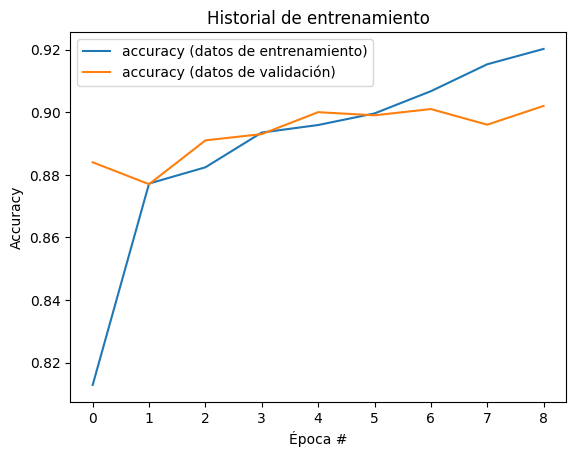

In [ ]:
# Gráfica del comportamiento de accuracy a lo largo del entrenamiento del modelo
plt.plot(history.history['accuracy'], label='accuracy (datos de entrenamiento)')
plt.plot(history.history['val_accuracy'], label='accuracy (datos de validación)')
plt.title('Historial de entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Época #')
plt.legend(loc="upper left")
plt.show()

### Historial de entrenamiento y validación del modelo (loss)

En esta gráfica se muestra cómo la métrica de `loss` progresa conforme se avanzan en las 5 épocas de entrenamiento.

La curva azul representa la pérdida obtenida con los datos de entrenamiento, mientras que la curva naranja representa la pérdida con los datos del conjunto de validación.

Ambas curvas bajan de manera constante, siendo cada vez menor la disminución a medida que pasa cada época (esto se cumple regularmente en las primeras 5 épocas).

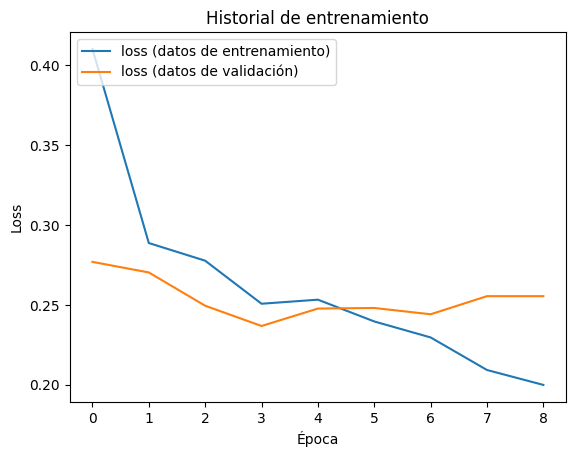

In [ ]:
# Gráfica del comportamiento de loss a lo largo del entrenamiento del modelo
plt.plot(history.history['loss'], label='loss (datos de entrenamiento)')
plt.plot(history.history['val_loss'], label='loss (datos de validación)')
plt.title('Historial de entrenamiento')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(loc="upper left")
plt.show()

# Evaluación del modelo en los conjuntos de validation y test

Después de entrenar el modelo, es necesario medir su desempeño en datos que no fueron usados durante el entrenamiento. Esto permite saber qué tan bien generaliza el modelo fuera de los ejemplos que ya vio.

El conjunto de validación fue usado durante el entrenamiento únicamente para monitorear el rendimiento del modelo en cada época. Mientras que el conjunto de test o prueba es completamente nuevo, así que muestra cómo se va a desempeñar el modelo realmente.

In [ ]:
# Evaluar el modelo en validation y test
print("\nEvaluación en validation:")
print(model.evaluate(val_model_ds))

print("\nEvaluación en test:")
print(model.evaluate(test_model_ds))



Evaluación en validation:
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.8847 - loss: 0.2615
[0.23673804104328156, 0.8930000066757202]

Evaluación en test:
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.6602 - loss: 0.8714
[0.6811649203300476, 0.7450000047683716]


# Conversión del conjunto de prueba en arreglos NumPy

El conjunto de prueba (`test_ds`) es originalmente un dataset de tensores, diseñado para ser procesado por TensorFlow. Sin embargo, para visualizar las imágenes, asignarles un ID y generar gráficos personalizados con `matplotlib`, es mucho más práctico trabajar con arrays NumPy.

Se emplea `test_ds`, que es el conjunto sin normalizar para mostrar las imágenes más adelante a la hora de seleccionar una imagen según un ID. Así, es más sencillo convertir a NumPy omitiendo el paso de desnormalizar cada imagen.

In [ ]:
# Listas auxiliares que contendrán los batches (conjuntos de tensores)
x_parts, y_parts = [], []
# Se recorren los tensores con las imágenes y etiquetas para convertirlas a NumPy e integrarlos a su respectiva lista
for imgs, labels in test_ds:   # test_ds: dataset sin normalizar
    x_parts.append(imgs.numpy())
    y_parts.append(labels.numpy())

# Unión de cada grupo de tensores (arreglos NumPy) para crear un sólo arreglo en las imágenes y otro en etiquetas.
X_test_np = np.concatenate(x_parts, axis=0)
y_true = np.concatenate(y_parts, axis=0)

#Mostrar cardinalidad (forma) de cada arreglo NumPy
print("X_test_np.shape:", X_test_np.shape)
print("y_true.shape:", y_true.shape)

# Redimensiónostrar arreglo NumPy de las etiquetas reales
y_true = np.asarray(y_true).reshape(-1).astype(int)
y_true

X_test_np.shape: (200, 128, 128, 3)
y_true.shape: (200, 1)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

# Predicciones del modelo sobre el conjunto de prueba

Una vez que el modelo está entrenado, se necesita obtener sus predicciones sobre el conjunto de prueba. Para ello se el dataset normalizado (test_model_ds), que es el formato adecuado para ser procesado por la red neuronal.

El siguiente bloque calcula:
* Las probabilidades por clase que produce el modelo.
* La etiqueta predicha para cada imagen con base en las probabilidades. Si la probabilidad de que la imagen sea un melanoma maligno es igual o mayor al 50%, se clasifica como melanoma maligno.

In [ ]:
# Obtener preds, siendo el arreglo de las probabilidades de que la imagen del melanoma sea maligno.
preds = model.predict(test_model_ds, verbose=1)   # test_model_ds = test_ds normalizado
print("preds.shape:", preds.shape)

# preds tiene shape (N,1)
preds = np.asarray(preds).reshape(-1)   # ahora se redimensiona
print("preds.shape:", preds.shape)

# Usando la base de preds, se calcula y_pred para etiquetar cada imagen.
y_pred = (preds >= 0.5).astype("int")
print("y_pred.shape:", y_pred.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
preds.shape: (200, 1)
preds.shape: (200,)
y_pred.shape: (200,)


Este es el arreglo de las probabilidades de que la imagen sea un tumor maligno. Será relevante para mostrar la posibilidad de que el tumor sea benigno o maligno.

In [ ]:
preds

array([0.4543092 , 0.5446228 , 0.02343801, 0.11441462, 0.2932105 ,
       0.96041256, 0.13492192, 0.9557785 , 0.40691042, 0.10327464,
       0.182421  , 0.68585175, 0.04196556, 0.69882435, 0.5745816 ,
       0.9410153 , 0.92039365, 0.03390047, 0.02503483, 0.6566958 ,
       0.19229415, 0.8943311 , 0.04318663, 0.8685832 , 0.8412466 ,
       0.34889975, 0.9837659 , 0.20562908, 0.37293732, 0.42387116,
       0.5468007 , 0.06192378, 0.9877755 , 0.67875785, 0.4718453 ,
       0.7018578 , 0.5616819 , 0.10400064, 0.1163495 , 0.05101995,
       0.4069988 , 0.1985855 , 0.34556615, 0.86371744, 0.04737587,
       0.97459847, 0.01136878, 0.06766483, 0.09107512, 0.04385028,
       0.19038059, 0.6619779 , 0.9994772 , 0.14295594, 0.95088327,
       0.30558857, 0.25953734, 0.11527931, 0.5223275 , 0.6446297 ,
       0.03936411, 0.968775  , 0.8752866 , 0.89850813, 0.6773466 ,
       0.36824203, 0.3829694 , 0.99946046, 0.48295337, 0.43805948,
       0.37055835, 0.5421796 , 0.84839654, 0.06764157, 0.31945

Y este es el arreglo de las etiquetas predichas por el modelo para cada imagen del conjunto de imágenes de prueba.

In [ ]:
y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

# Reporte de clasificación y matriz de confusión

Para evaluar el desempeño del modelo para clasificar los datos del conjunto de datos de prueba se emplearon las siguientes herramientas:

**Reporte de clasificación**

Es una herramienta que evalúa el rendimiento de un modelo de aprendizaje automático (machine learning) resumiendo métricas clave como Precisión (Precision), Recuperación (Recall), Puntuación F1 (F1-Score) y Soporte (Support) para cada clase.

Sus métricas son:

* Accuracy: Indica la proporción de predicciones correctas sobre el total de predicciones. Un modelo perfecto no tendría ningún falso positivo ni ningún falso negativo y, por lo tanto, tendría una precisión de 1.0 o 100% (lo cual implica completa memorización del conjunto de datos).
* Precision: Mide la proporción de verdaderos positivos entre todas las predicciones positivas. Es útil cuando el costo de los falsos positivos es alto. Un modelo hipotético perfecto no tendría ningún falso positivo y, por lo tanto, una precisión de 1.0.
* Recall: Mide la proporción de verdaderos positivos entre todas las instancias positivas reales. Es importante cuando el costo de los falsos negativos es alto. Un modelo hipotético perfecto no tendría ningún falso negativo y, por lo tanto, una recuperación (TPR) de 1.0, es decir, una tasa de detección del 100%.
* F1-Score: una medida de la media armónica de precisión y recuperación, ofreciendo un equilibrio entre ambas. Su fórmula es F1= 2 *(Precision * Recall)/(Precision+Recall)
* Support: Se refiere al número de ocurrencias reales de la clase en los datos proporcionados (es decir, el número de muestras verdaderas para esa clase).

**Matriz de confusión**

Muestra gráficamente la comparación entre los valores predichos y reales, con los siguientes parámetros: verdaderos positivos (VP), donde el modelo predijo correctamente la clase positiva; verdaderos negativos (VN), donde el modelo predijo correctamente la clase negativa; falsos positivos (FP), donde el modelo predijo erróneamente la clase positiva y falsos negativos (FN), donde el modelo predijo erróneamente la clase negativa.

Reporte de clasificación-Predicción de imágenes de tipos de melanoma
              precision    recall  f1-score   support

      benign       0.86      0.59      0.70       100
   malignant       0.69      0.90      0.78       100

    accuracy                           0.74       200
   macro avg       0.77      0.74      0.74       200
weighted avg       0.77      0.74      0.74       200



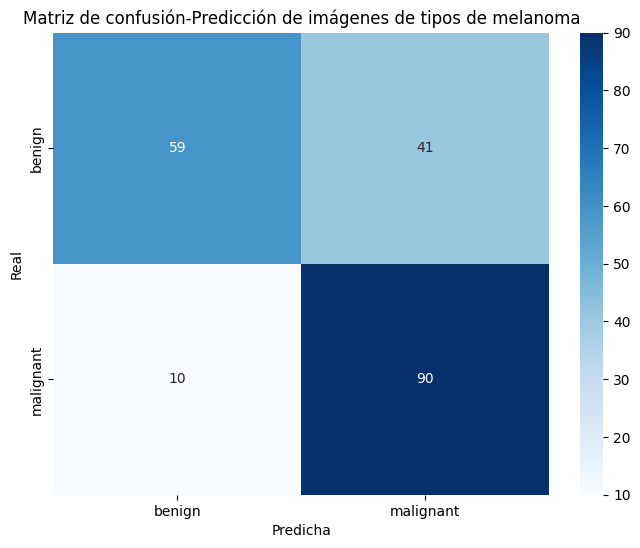

In [ ]:
# Reporte de clasificación
print("Reporte de clasificación-Predicción de imágenes de tipos de melanoma")
# Se construye a partir de la comparación de los datos verdaderos y de los datos predichos
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
# Se construye a partir de la comparación de los datos verdaderos y de los datos predichos
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de confusión-Predicción de imágenes de tipos de melanoma")
plt.show()

# Función para mostrar una imagen y comparación entre el tipo de melanoma real y el predicho en el modelo

Esta función permite visualizar cualquier imagen del conjunto de prueba (test) usando su ID global, mostrando a la vez:
* La imagen original.
* Su etiqueta real (benigno/maligno).
* La predicción del modelo.
* Las probabilidades calculadas para cada clase.
* Un gráfico de barras de probabilidad.

Sirve para analizar visualmente los aciertos y errores del modelo.


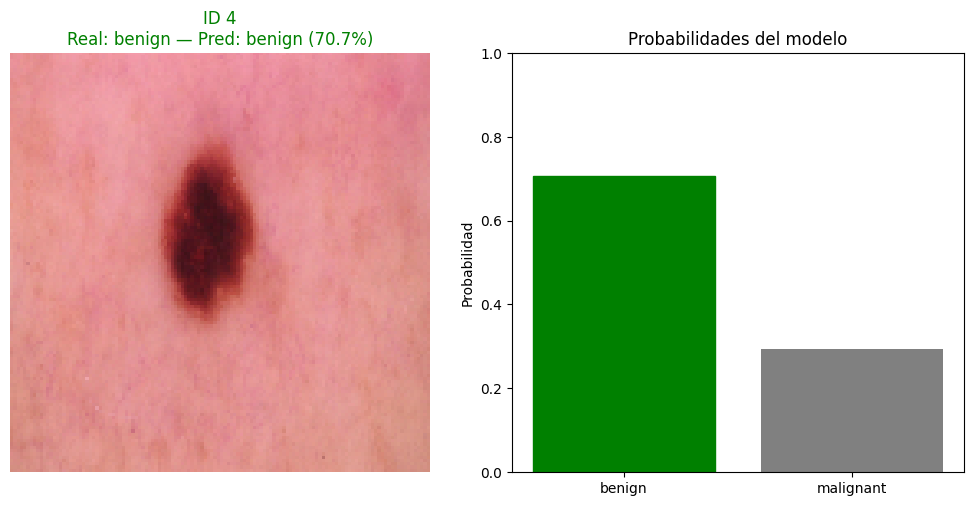

In [ ]:
def show_test_id(ID):
    # Calcular número de imágenes (comenzando desde cero)
    N = X_test_np.shape[0]
    # Mostrar error en caso de estar fuera de rango
    if ID < 0 or ID >= N:
        raise IndexError(f"ID fuera de rango (0 - {N-1}). Pedido: {ID}")
    # Mostrar imagen original dependiendo del ID
    img = X_test_np[ID].astype("uint8")
    # Extraer etiqueta real de la imagen
    true_lbl = int(y_true[ID])        # 0 = benigno, 1 = maligno
    # Extraer las probabilidades de que la imagen sea melanoma maligno y benigno
    prob_maligno = float(preds[ID])
    prob_benigno = 1 - prob_maligno

    # Clase predicha
    pred_lbl = int(y_pred[ID])

    # Determinar cuál es la probabilidad a mostrar y multiplicarla por 100 para mostrarla en porcentaje
    pred_prob = (prob_maligno if pred_lbl == 1 else prob_benigno) * 100
    # Si la etiqueta predicha coincide con la real se muestra en verde, de lo contrario se muestra en rojo
    color = "green" if true_lbl == pred_lbl else "red"

    plt.figure(figsize=(10,5))

    # Imagen
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"ID {ID}\nReal: {class_names[true_lbl]} — Pred: {class_names[pred_lbl]} ({pred_prob:.1f}%)",
        color=color
    )

    # Barras benigno/maligno
    plt.subplot(1,2,2)
    probs_array = [prob_benigno, prob_maligno]
    bars = plt.bar([0,1], probs_array, color="gray")

    # Colores de barras
    bars[pred_lbl].set_color(color)           # clase predicha
    if pred_lbl != true_lbl:
        bars[true_lbl].set_color("lightgreen")  # clase correcta si falló

    plt.xticks([0,1], class_names, rotation=0)
    plt.ylim(0, 1)
    plt.ylabel("Probabilidad")
    plt.title("Probabilidades del modelo")
    plt.tight_layout()
    plt.show()

show_test_id(4)

# Conclusiones

En la fase experimental, se observó un rendimiento favorable en el conjunto de validación, alcanzando una exactitud (accuracy) aproximada del 90%. Sin embargo, la evaluación final en el conjunto de prueba registró una disminución del rendimiento al ~70%. A pesar de ello, el modelo sostuvo una sensibilidad (recall) destacada para la clase maligna. Se concluye que, si bien la arquitectura propuesta logra identificar patrones discriminativos clave, resulta insuficiente para capturar la complejidad visual y diversidad de las muestras, resaltando la necesidad de integrar arquitecturas más robustas en trabajos futuros.